# Circle Detection

#### Basics of Circleline Method
A circle can be represented as `(x - h)**2 + (y - k)**2 = r**2` 
* To detect circles, we may fix a point (x, y). So we have to find 3 parameters: a, b and r. 
* The value of a (x-coordinate of the center) may range from 1 to rows
* The value of b (y-coordinate of the center) may range from 1 to cols
* The value of r (raduis of the circle) may range from 1 to maxRadius = sqrt{rows^2 + cols^2}

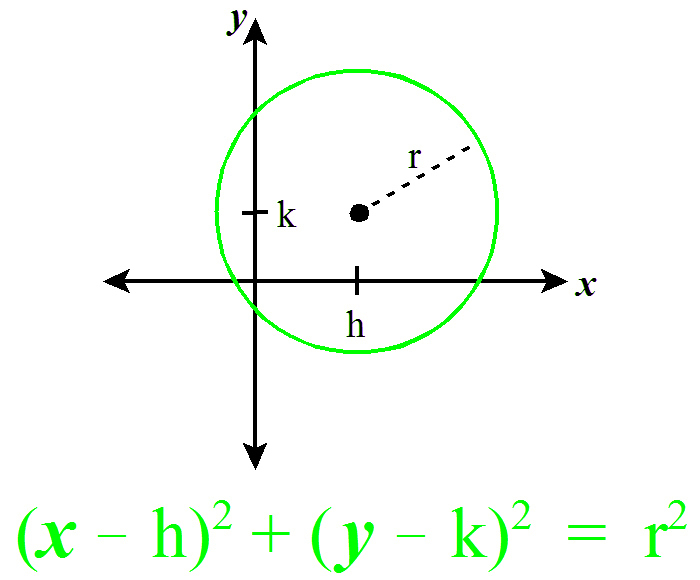

### Algorithm

1. **Pre-processing the image:** Apply blurring, grayscale and an edge detector on the image. This is done to ensure the circles show as darkened image edges.

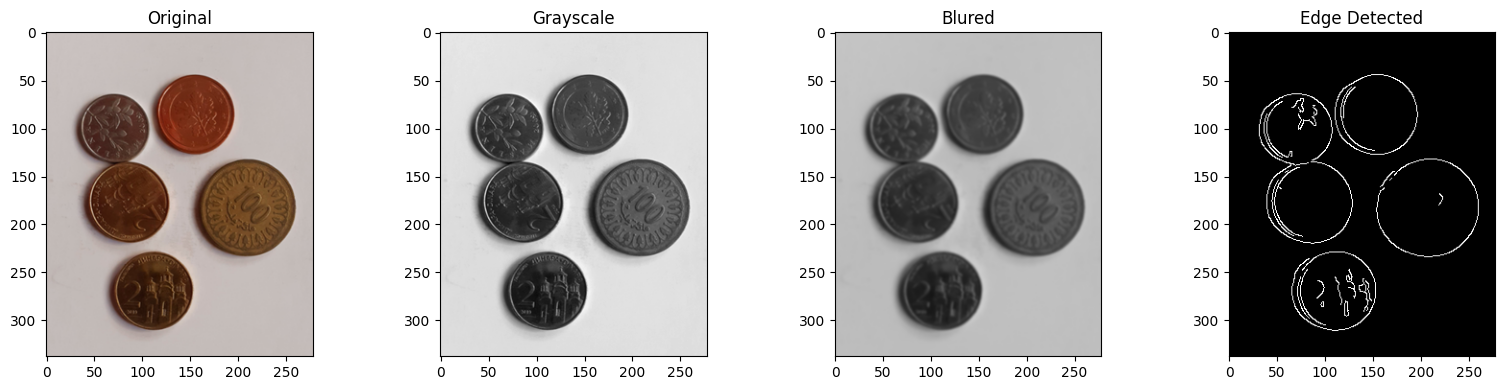

In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from collections import defaultdict

# Important parameters
min_edge_threshold = 50
max_edge_threshold = 150

# Read image
image = cv2.imread(r'D:\College_work\CV\Lucidum Lab\Task1-Noisy-Visions-Filtering-and-Edge-Perception\pyQt\data\image004.png')

# Apply Canny edge detection
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blured_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
edged_image = cv2.Canny(blured_image, min_edge_threshold, max_edge_threshold)

# Display all images
plt.figure(figsize=(16,4))
plt.subplot(141), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(142), plt.imshow(gray_image, cmap='gray'), plt.title('Grayscale')
plt.subplot(143), plt.imshow(cv2.cvtColor(blured_image, cv2.COLOR_BGR2RGB)), plt.title('Blured')
plt.subplot(144), plt.imshow(edged_image, cmap='gray'), plt.title('Edge Detected')
plt.tight_layout()
plt.show()

In [2]:
# Image dimentions
height, width = image.shape[:2]
print("height, width:", height,",", width)

# R and Theta ranges
r_min = 20
# Adjusting the coming three parameters as accuracy takes much time 
r_max = min(height, width) // 2
delta_r = 1
num_thetas = 50
dtheta = int(360 / num_thetas)

# Thetas is bins created from 0 to 360 degree with increment of the dtheta
thetas = np.arange(0, 360, step=dtheta)

# Radius ranges from r_min to r_max 
rs = np.arange(r_min, r_max, step=delta_r)

print("rs shape, thetas shape: ",rs.shape, ",", thetas.shape)
print("rs: ",rs[0:5], rs[-5:])
print("thetas: ",thetas[0:5], thetas[-5:])

height, width: 338 , 278
rs shape, thetas shape:  (119,) , (52,)
rs:  [20 21 22 23 24] [134 135 136 137 138]
thetas:  [ 0  7 14 21 28] [329 336 343 350 357]


* **Precalculations**
    1. For each possible radius r and angle θ, they calculate points that would lie on a circle of that radius
    2. The equations x = x_center + rcos(θ) and y = y_center + rsin(θ) are the parametric equations of a circle
    3. The code pre-calculates all possible (r, rcosθ, rsinθ) combinations that will be used to vote for circle centers
    4. When an edge point is found, these pre-calculated values help determine where the center of a potential circle could be

In [3]:
# Calculate Cos(theta) and Sin(theta) 
cos_thetas = np.cos(np.deg2rad(thetas))
sin_thetas = np.sin(np.deg2rad(thetas))

# Evaluate and keep ready the candidate circles dx and dy for different delta radius
# based on the the parametric equation of circle.
circle_candidates = []
for r in rs:
    for t in range(num_thetas):
        circle_candidates.append((r, int(r * cos_thetas[t]), int(r * sin_thetas[t])))

circle_candidates = np.array(circle_candidates)
print("circle_candidate shape: ", circle_candidates.shape)

circle_candidate shape:  (5950, 3)


2. **Initializing the Accumulator Matrix:** 
    * Hough Accumulator, we are using defaultdic instead of standard dict as this will initialize for key which is not aready present in the dictionary instead of throwing exception.
    * Dimentions of  rows * cols * maxRadius with zeros.
2. **Voting Process**
    * Iterate through each edge point (x, y).
    * For each edge point:
        * Iterate through all candidate circles.
        * For each candidate circle (rho, theta):
            * `x_center = x - rcos_t` calculates the potential circle center's x coordinate
            * `y_center = y - rsin_t` calculates the potential circle center's y coordinate
            * Together these form a possible circle center (x_center, y_center) with radius r
            * The `accumulator[(x_center, y_center, r)] += 1` adds a vote for this circle configuration

In [4]:
accumulator = defaultdict(int)

for y in range(height):
    for x in range(width):
        # Check for white pixels
        if edged_image[y][x] != 0: 
            # Found an edge pixel so now find and vote for circle from the candidate circles passing through this pixel.
            for r, rcos_t, rsin_t in circle_candidates:
                x_center = x - rcos_t
                y_center = y - rsin_t
                accumulator[(x_center, y_center, r)] += 1 

3. **Finding Peaks**
    * Sorts accumulator entries by number of votes (descending order using -i[1])
    * The vote percentage represents how many edge points voted for this circle relative to the maximum possible votes
    * If vote percentage exceeds bin_threshold, the circle is considered a peak

In [5]:
bin_threshold = 0.4
output_img = image.copy()
# Output list of detected circles. A single circle would be a tuple of (x,y,r,threshold) 
out_circles = []
# Sort the accumulator descindingly based on the votes for the candidate circles 
sorted_accumulator = sorted(accumulator.items(), key=lambda i: -i[1])

for candidate_circle, votes in sorted_accumulator:
    x, y, r = candidate_circle
    current_vote_percentage = votes / num_thetas
    if current_vote_percentage >= bin_threshold: 
      # Shortlist the circle for final result
      out_circles.append((x, y, r, current_vote_percentage))

4. **Post-processing to remove duplicate or overlapping circle detections**
    * Sets pixel_threshold = 5 as the minimum distance between circles
    * Creates a new list postprocess_circles to store filtered circles
    * For each detected circle (x,y,r,v):
        * Compares it with all previously accepted circles
        * Checks if the current circle is far enough from existing circles by verifying:
            * x-coordinate difference > pixel_threshold
            * y-coordinate difference > pixel_threshold
            * radius difference > pixel_threshold
        * Only adds the circle if it's sufficiently different from all existing circles

In [6]:
post_process = True
if post_process :
    pixel_threshold = 5
    postprocess_circles = []
    for x, y, r, v in out_circles:
      if all(abs(x - xc) > pixel_threshold or abs(y - yc) > pixel_threshold or abs(r - rc) > pixel_threshold for xc, yc, rc, v in postprocess_circles):
        postprocess_circles.append((x, y, r, v))
    out_circles = postprocess_circles

5. **Draw Circles**

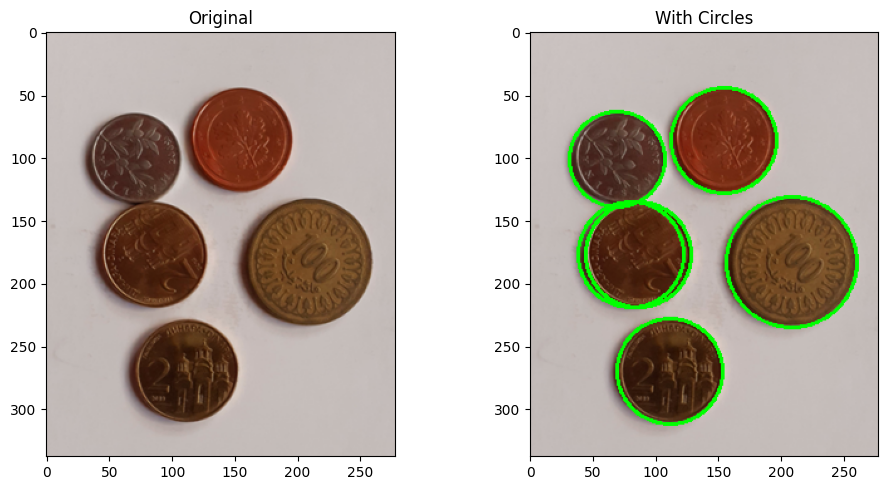

In [7]:
# Draw shortlisted circles on the output image
for x, y, r, v in out_circles:
    output_img = cv2.circle(output_img, (x,y), r, (0,255,0), 2)

# Create a single figure for all plots
plt.figure(figsize=(10,5))

# First subplot: Original image
plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original')

# Second subplot: Image with circles
plt.subplot(122)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title('With Circles')

plt.tight_layout()
plt.show()